In [107]:
import torchmetrics
import torch
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader

from wdd.data_handling.pull_data import get_processed_data
from wdd.data_handling.torch_dataset import WaferDataset
from wdd.model.cnn_spp import CNN_SPP_Net


# Introduction

In this notebook, I outline the process for training a ML model to detect defects type in silicon wafers. I originally found the data from an old paper [link](https://www.sciencedirect.com/science/article/abs/pii/S0167931704005374). The raw data can be found at my huggingface dataset [link](https://huggingface.co/datasets/lslattery/wafer-defect-detection/blob/main/LSWMD.pkl).

I processed the data, removing unlabeled wafers, fixing text mistakes and generally making the data usable for our pytorch model. The resulting data is now 2D pixel maps with one of nine corresponding defect labels. Below, I show example wafer maps for each of the nine defects and the failure type count.

In [108]:
train_df,test_df=get_processed_data()

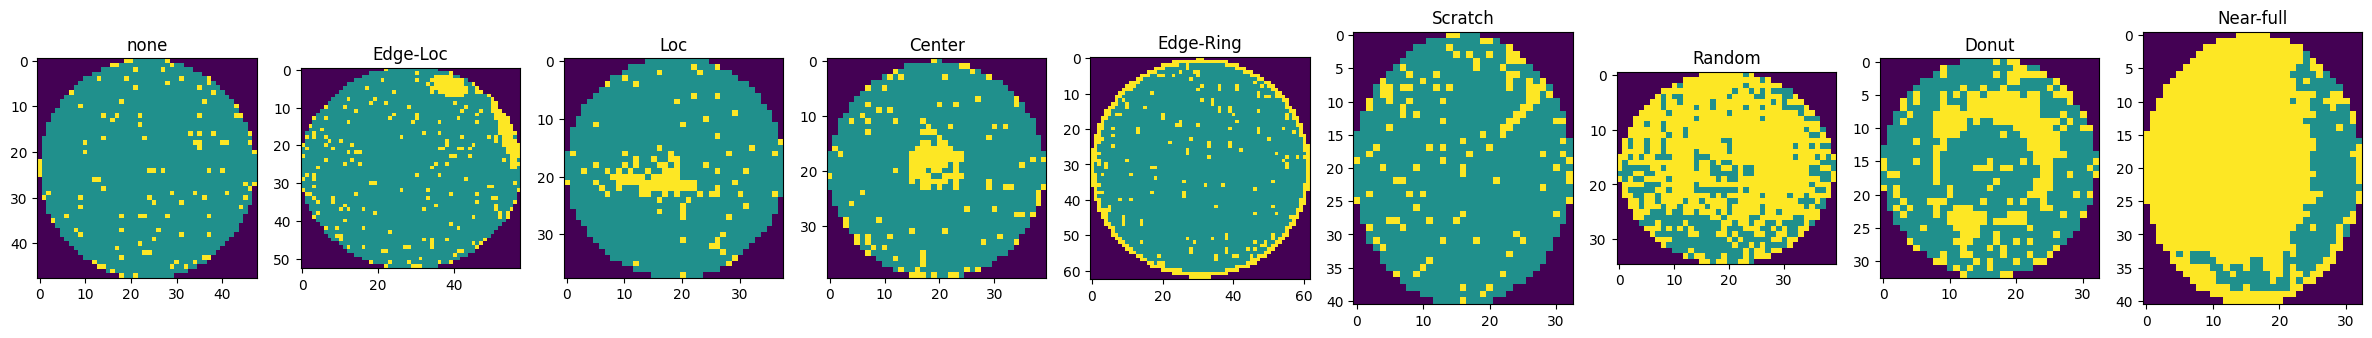

In [109]:
failureTypes=['none','Edge-Loc','Loc','Center','Edge-Ring','Scratch','Random','Donut','Near-full']
exampleWaferMaps=dict([(ftype,train_df[train_df['failureType']==ftype].waferMap.iat[0]) for ftype in failureTypes])

fig, axs = plt.subplots(1,len(failureTypes),figsize=(30,10))
for i,(key,item) in enumerate(exampleWaferMaps.items()):
    axs[i].set_title(key)
    axs[i].imshow(item)

<BarContainer object of 9 artists>

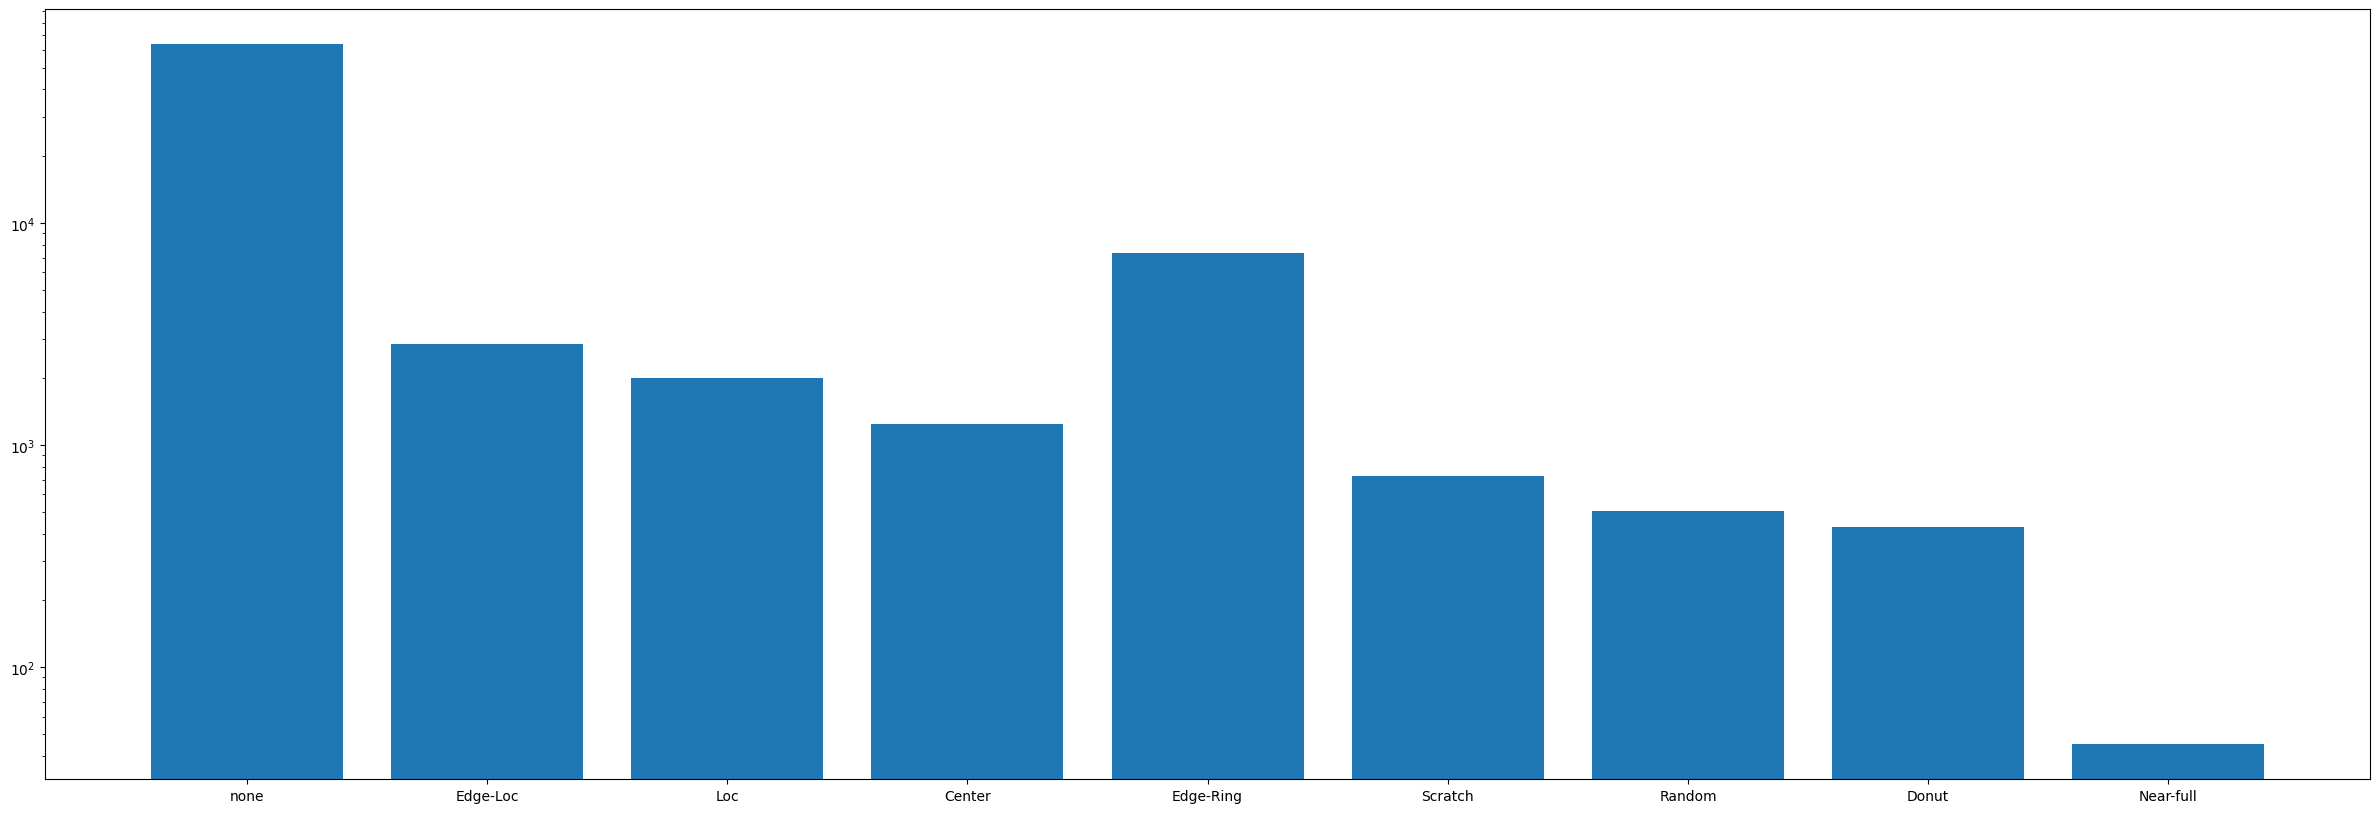

In [110]:
failureTypeCounts=dict([(ftype,len(train_df[train_df['failureType']==ftype])) for ftype in failureTypes])

fig, ax = plt.subplots(1,figsize=(30,10))
ax.set_yscale('log')
ax.bar(failureTypeCounts.keys(),failureTypeCounts.values())

From these two plots it is clear that there are two major hurdles with the data hurdles I will have to overcome in order to train the classifier:

-Each of the wafer maps has different aspect ratios and picture sizes meaning standard CNN architectures won't work without modification.

-There is a large class imbalance problem with the vast majority of wafers having the 'none' defect while 'Near-full' defects are only 45 examples in the training data.

To solve the first issue, I will use a CNN architecture with spatial pyramid pooling [link](https://ieeexplore.ieee.org/abstract/document/7005506?casa_token=IrPcFUSGv4QAAAAA:lkBIGNYF0VfQNAydMzfDMBOKapBXDBXEOz4EzUvxpEv11IzszLgmOeYOmQfmZqMNtkfSZHpY5A) in order to adapt our CNN to work with varying input sizes for our wafer maps. One can see my implementation of the CNN with SPP in /wdd/model/cnn_spp.py and the model parameters are set in /run_model.py. Using this method, batching is more difficult as I would have to group same size wafer maps into batches. Instead, for the purposes of this demo I simply set batch size equal to one but improvements in training speed could be made by implementing a batch sampler that groups wafer maps of the same size together.

The second issue is perhaps the more difficult to solve. I will mitigate the problem in a few different ways. In the first, when training I will perform weighted sampling wherein training samples are drown evenly from each class during each epoch. The validation loss will then be the class-weighted cross entropy loss. I will also consider synthetically generating more data. Looking at the above samples, it becomes clear that it may be reasonable to assume their is a rotational symmetry to the wafer defects. I would like my classifier to be able recognize a defect no matter the orientation on the wafer. Therefore, I also test model performance using training data that, when sampled, is rotated by a random angle.

Using wandb to log the run, I attempt a first training run. Below is a plot of the training loss and validation loss vs. step.

<img src="./figs/example_training_loss.svg" width="700px">
<img src="./figs/example_validation_loss.svg" width="700px">

One thing to note is that the valdiation loss is noisy. This is due the small number of samples for some of the defect classes. Noisy validation loss will make hyperparameter tuning difficult as the noise will make it more difficult to distinguish between model performance. Instead, I introduce a new metric, the exponential moving average of the validation loss. I use the formula:

exp_avg_validation_loss = current_validation_loss * $\alpha$ + (1-$\alpha$)*exp_avg_validation_loss

with $\alpha=0.2$ to compute the exponential moving average. The exponential moving average is less noisy and I wll use that as the metric to minimize in hyperparameter tuning. Below I present the results for hyperparmeter tuning using wandb's sweep functionality. I use the Bayes method for new hyperparameter selection and the hyperband method for early termination. See /hyperparameter_sweeps.yaml for an example of a sweep configuration.

# Results

After performing the hyperparameter sweeps, I select the best performing (lowest exponential moving average validation loss) model trained with and without rotational transformation applied to training data. As shown in these two models (an in others not shown) the model trained using rotational transformations (green) is able to achieve lower exponential moving average validation loss with higher training loss than the model trained without rotational transformations (orange). This is evidence that the rotational transformations are helping the model generalize.

<img src="./project_results/best_training_loss.svg" width="700px">
<img src="./project_results/best_exp_val_loss.svg" width="700px">

Next we look at the balanced F1 score and the F1 score by class using the reserved test data for each of the models.


In [111]:
cnn_channels=tuple(2**(i) for i in range(2))
spp_output_sizes=[(1+2*i,1+2*i) for i in range(5)]
linear_output_sizes=tuple(9*2**(i-1) for i in range(4,0,-1))

model_parameters=dict(
    cnn_channels=cnn_channels,
    spp_output_sizes=spp_output_sizes,
    linear_output_sizes=linear_output_sizes,
    )

model = CNN_SPP_Net(model_parameters)
a=torch.load('./project_results/cnn_spp_net_2022-09-28T10%3A32%3A48.554950_0_.pt')
del a['validLossfn.weight']
model.load_state_dict(a)

<All keys matched successfully>

In [112]:
test_set=WaferDataset(test_df)
testLoader=DataLoader(test_set, batch_size=1, shuffle=True, num_workers=0)
y_trues,y_preds,_ = model.predict(testLoader)

balanced_f1=torchmetrics.F1Score(num_classes=9,average='macro')(y_trues,y_preds)
by_class_f1=torchmetrics.F1Score(num_classes=9,average='none')(y_trues,y_preds)

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

# Future Improvements

Unfortunately, I need to work on my thesis so I will truncate the project. In this section, I will discuss several methods that I think would lead to improved model performance (outside of adding additional data).

-I think the most obvious method for improving the model would be two split it into two classifiers. One classifier would predict 'defect' or 'no defect' while the second classifier would predict the defect for all data the previous model predicts has a defect. On a quick test with no hyperparameter tuning I achieved a >99% balanced accuracy for a CNN with spatial pyramid pooling predicting defect or no defect.

-In my work with optimizing tensornetworks (not neural networks) and quantum circuits, I've found that Adam optimizers often have trouble with noisy loss functions. It may be the case that standard SGD with a learning rate scheduler may perform better in this particular case.

-Coding a pytorch batch sampler would let me take advantage parallelization speedups and allow me to iterate faster and run more hyperparameter sweeps.

-Implementing K-Fold cross vaidation could help with model selection as the averaging over folds could significantly reduce the noise in the validation loss. However, I am currently limited in compute resources so I chose not to implement.